# Инициализация

In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import keras
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Pave_\AppData\Local\Temp\ipykernel_3720\460933490.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


In [2]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50
#Число классов
num_classes = 6

# Загрузка тренировочных данных

In [23]:
train = pd.read_csv('toxicCommentsDataSet/toxicCommentsTrain.csv')

In [25]:
#Получение комментариев
comments = train['comment_text']

'"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "'

In [5]:
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Токенизация

In [6]:
tokenizer = Tokenizer(num_words=num_words)

In [7]:
#Обучение токенайзера
tokenizer.fit_on_texts(comments)

In [8]:
train_sequences = tokenizer.texts_to_sequences(comments)

In [9]:
x_train = pad_sequences(train_sequences, maxlen=max_comment_len)

# Загрузка тестовых данных

In [26]:
test_comments = pd.read_csv('toxicCommentsDataSet/toxicCommentsTest.csv')

In [27]:
test_labels = pd.read_csv('toxicCommentsDataSet/toxicCommentsTestLabels.csv')

In [28]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [29]:
test = test_full[test_full['toxic']!=-1]
len(test)

63978

# Токенизация

In [14]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

In [15]:
y_test = test[['toxic',	'severe_toxic',	'obscene', 'threat',	'insult',	'identity_hate']]

In [16]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

# Обучение модели

In [17]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=36, input_length=max_comment_len,
                    embeddings_regularizer=keras.regularizers.l2(0.0001)))
model.add(Conv1D(filters=32, kernel_size=5, activation='elu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=108, activation='elu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 36)            360000    
                                                                 
 conv1d (Conv1D)             (None, 46, 32)            5792      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 736)               0         
                                                                 
 dense (Dense)               (None, 108)               79596     
                                                                 
 dense_1 (Dense)             (None, 6)                 654       
                                                        

In [18]:
history_model = model.fit(x_train,
                          y_train,
                          epochs=15,
                          batch_size=1024,
                          validation_split=0.2)

Epoch 1/15
125/125 [==============================] - 11s 75ms/step - loss: 0.1416 - auc: 0.8932 - accuracy: 0.9805 - val_loss: 0.0956 - val_auc: 0.9549 - val_accuracy: 0.9940
Epoch 2/15
125/125 [==============================] - 7s 56ms/step - loss: 0.0833 - auc: 0.9619 - accuracy: 0.9628 - val_loss: 0.0824 - val_auc: 0.9672 - val_accuracy: 0.9893
Epoch 3/15
125/125 [==============================] - 8s 61ms/step - loss: 0.0736 - auc: 0.9691 - accuracy: 0.9243 - val_loss: 0.0722 - val_auc: 0.9706 - val_accuracy: 0.9658
Epoch 4/15
125/125 [==============================] - 9s 68ms/step - loss: 0.0698 - auc: 0.9713 - accuracy: 0.9501 - val_loss: 0.0716 - val_auc: 0.9718 - val_accuracy: 0.9907
Epoch 5/15
125/125 [==============================] - 8s 65ms/step - loss: 0.0676 - auc: 0.9727 - accuracy: 0.9735 - val_loss: 0.0680 - val_auc: 0.9713 - val_accuracy: 0.9940
Epoch 6/15
125/125 [==============================] - 10s 77ms/step - loss: 0.0660 - auc: 0.9736 - accuracy: 0.9890 - val_lo

In [30]:
model.evaluate(x_test, y_test)
len(x_test)

2000/2000 [==============================] - 7s 4ms/step - loss: 0.0869 - auc: 0.9675 - accuracy: 0.9974


63978

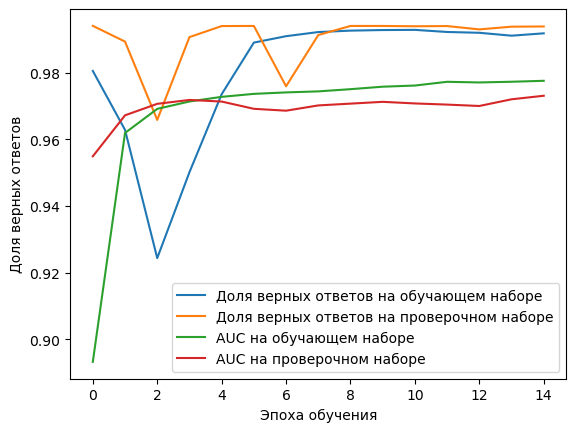

In [20]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.plot(history_model.history['auc'],
         label='AUC на обучающем наборе')
plt.plot(history_model.history['val_auc'],
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()